# Quantus + NLP
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/understandable-machine-intelligence-lab/Quantus/main?labpath=tutorials%2FTutorial_NLP_Demonstration.ipynb)


This tutorial demonstrates how to use the library for evaluation explanation of text classification models.
For this purpose, we use a pre-trained [Distilbert](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) model from [Huggingface Hub](https://huggingface.co/models) and [GLUE/SST2](https://huggingface.co/datasets/sst2) dataset.

Author: Artem Sereda

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1eWK9ebfMUVRG4mrOAQvXdJ452SMLfffv?usp=sharing)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
from datasets import load_dataset
import tensorflow as tf
import logging
import random
import matplotx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from transformers import TFAutoModelForSequenceClassification

import quantus
from quantus.helpers.plotting import plot_model_parameter_randomisation_experiment, plot_token_flipping_experiment
from quantus.functions.normalise_func import normalize_sum_to_1
from quantus.helpers.utils_nlp import map_explanations
from quantus.helpers.utils import get_wrapped_model
from quantus.helpers.plotting import visualise_explanations_as_pyplot


#plt.style.use(matplotx.styles.dufte)
logging.getLogger().setLevel(logging.WARNING)
random.seed(42)
tf.config.list_physical_devices()

## 1) Preliminaries

### 1.1 Load pre-trained model and tokenizer from [huggingface](https://huggingface.co/models) hub

In [ ]:
model = get_wrapped_model(
    TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
)

### 1.2 Load test split of [GLUE/SST2](https://huggingface.co/datasets/sst2) dataset

In [ ]:
BATCH_SIZE = 32

dataset = load_dataset("sst2")["test"]
x_batch = dataset["sentence"][:BATCH_SIZE]
random.shuffle(x_batch)

### 1.3 Run an example inference and demonstrate models predictions.

In [ ]:
def decode_labels(y_batch: np.ndarray):
    """A helper function to map integer labels to human-readable class names."""
    return [model.get_model().config.id2label[i] for i in y_batch]


y_batch = model.predict(x_batch).argmax(axis=-1)

# Show the x, y data.
pd.DataFrame([x_batch[:10], decode_labels(y_batch[:10])]).T

### 1.4 Visualise the explanations.

All available XAI methods can be listed with `quantus.nlp.available_xai_methods()`

In [ ]:
xai_methods = quantus.available_nlp_xai_methods_tf()
xai_methods.sort()
xai_methods

The main "entrypoint" for using built-in XAI methods is `quantus.explain`

In [ ]:
mini_x_batch = ["director rob marshall went out gunning to make a great one ."]
mini_y_batch = model.predict(mini_x_batch).argmax(axis=-1)
mini_a_batch = []

pbar = tqdm(xai_methods)
for i in pbar:
    pbar.desc = i
    a = quantus.explain(model, mini_x_batch, mini_y_batch, method=i)
    mini_a_batch.append(a[0])

mini_a_batch = map_explanations(mini_a_batch, normalize_sum_to_1)
visualise_explanations_as_pyplot(mini_a_batch, xai_methods)
plt.show()

## 2) Quantitative analysis using Quantus.
To see all available metric and their category, we can run `quantus.available_nlp_metrics()`

In [ ]:
quantus.available_nlp_metrics()

In [72]:
# We will need it later
# fmt: off
unk_token_embedding = model.embedding_lookup([model.tokenizer.unk_token_id])[0, 0]
# fmt: on

metrics = {
    # By default, perturbation is applied to embeddings inputs.
    "Average Sensitivity": quantus.AvgSensitivity(nr_samples=10, disable_warnings=True),
    "Max Sensitivity": quantus.MaxSensitivity(
        nr_samples=10,
        disable_warnings=True,
        # Perturbation type is inferred from perturb_func signature.
        perturb_func=quantus.spelling_replacement,
        normalise=True,
        normalise_func=normalize_sum_to_1
    ),
    "Relative Input Stability": quantus.RelativeInputStability(
        nr_samples=10,
        disable_warnings=True,
        perturb_func=quantus.spelling_replacement,
        normalise=True,
        normalise_func=normalize_sum_to_1
    ),
    "Relative Output Stability": quantus.RelativeOutputStability(
        nr_samples=10,
        disable_warnings=True,
        perturb_func=quantus.spelling_replacement,
        normalise=True,
        normalise_func=normalize_sum_to_1
    ),
    "Relative Representation Stability": quantus.RelativeRepresentationStability(
        nr_samples=10,
        disable_warnings=True,
        perturb_func=quantus.spelling_replacement,
        normalise=True,
        normalise_func=normalize_sum_to_1
    ),
    "Model Parameter Randomisation": quantus.ModelParameterRandomisation(
        seed=42,
        disable_warnings=True,
        perturb_func=quantus.spelling_replacement,
        normalise=True,
        normalise_func=normalize_sum_to_1
    ),
    "Random Logit_1": quantus.RandomLogit(
        num_classes=2,
        seed=42,
        disable_warnings=True,
        normalise=True,
        normalise_func=normalize_sum_to_1,

    ),
    "Random Logit_2": quantus.RandomLogit(
        num_classes=2,
        seed=42,
        disable_warnings=True,
    ),
    "Token Flipping": quantus.TokenFlipping(
        disable_warnings=True,
        abs=True,
        perturb_func=quantus.spelling_replacement,
        normalise=True,
        normalise_func=normalize_sum_to_1
    ),
}

# By default, qn.explain is used to generate explanations.
call_kwargs = {
    # We use GradXInput as default method for all methods.
    "explain_func_kwargs": {"method": "GradXInput"},
    # We evaluate Relative Input Stability for IntGrad with different baselines.
    "Relative Input Stability": [
        {
            "explain_func_kwargs": {
                "method": "IntGrad",
            }
        },
        {
            "explain_func_kwargs": {
                "method": "IntGrad",
                "baseline_fn": tf.function(lambda x: unk_token_embedding),
            }
        },
    ],
}

# Explain_func_kwargs are passed only to metrics' __call__ method.
result = quantus.evaluate_nlp(
    metrics=metrics,
    model=model,
    x_batch=x_batch,
    y_batch=y_batch,
    call_kwargs=call_kwargs
)

Evaluation...:   0%|          | 0/1 [00:00<?, ?it/s]

### 2.2 Results visualisation

For pruning task (default one) the tokens are removed in order of increasing relevance scores.
We expect Mean Squared Error to increase as we remove more important ones, 
which acts as a proof that higher scores are assigned to important features.

In [ ]:
plot_token_flipping_experiment(
    result["Token Flipping"],
    style=matplotx.styles.dufte
)
plt.show()

Model Parameter Randomisation shows us how layers' weights correlate with explanations.
0 - means randomizing layers weights changes explanation completely
1 - means randomizing layers weighs did not change explanation at all.

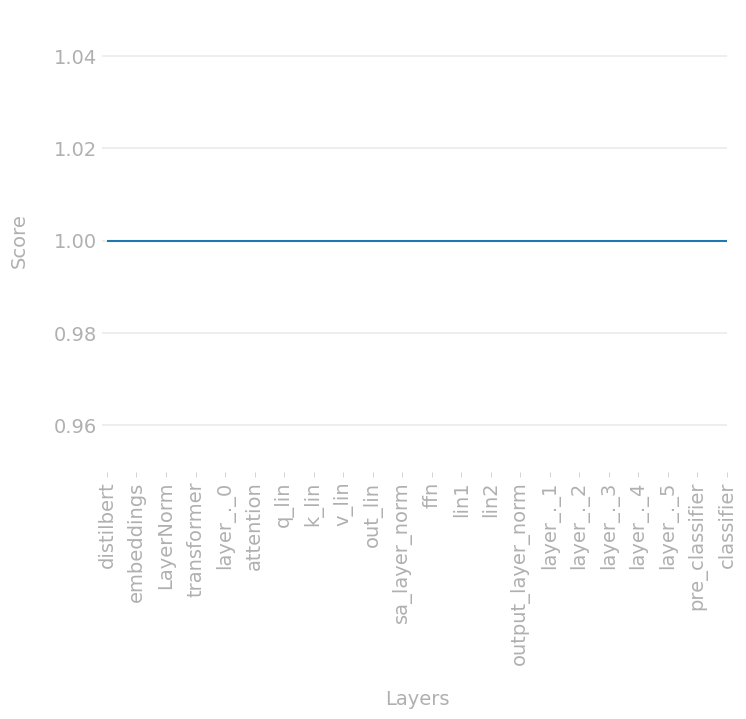

In [74]:
mpr = result["Model Parameter Randomisation"]
with plt.style.context(matplotx.styles.dufte):
    plot_model_parameter_randomisation_experiment(mpr)
    plt.show()

Robustness metrics show us how sensitive are explanations to slight perturbations.
For this category it is impossible to give general advice. Typically,
- Higher values could mean explanations take more inputs into account, than model
- Lower values could mean explanations are highly biased against certain features from input space (tokens).

In [ ]:
with plt.style.context(matplotx.styles.dufte):
    pd.DataFrame.from_dict(
    {
        k: v
        for k, v in result.items()
        if k
        in (
            "Average Sensitivity",
            "Max Sensitivity",
        )
    }
    ).boxplot()
    # plt.yscale("log")
    plt.title("Sensitivity metrics comparison")
    plt.show()

In [ ]:
rs = {
    "RIS_0": result["Relative Input Stability"][0],
    "RIS_{unk}": result["Relative Input Stability"][1],
    "ROS": result["Relative Output Stability"],
    "RRS": result["Relative Representation Stability"]
}

with plt.style.context(matplotx.styles.dufte):
    pd.DataFrame.from_dict(rs).boxplot()
    plt.yscale("log")
    plt.title("Relative Stability metrics comparison")
    plt.show()